In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

### a) Making our potential

In [3]:
def get_potential(n, dim = 2):
    
    dx = np.arange(n)
    
    pot = np.zeros([n,n])
    x,y = np.meshgrid(dx,dx)
    dr = np.sqrt(x**2 + y**2)
    dr[0,0] = 1 # Set temporarily to avoid error
    pot = -4.1*np.log(dr)/2/np.pi
    pot[0,0] = 1 + (pot[1,0] + pot[0,1])/2
        
    return pot

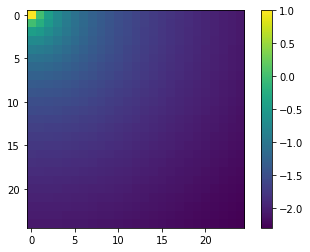

In [4]:
V = get_potential(25)
plt.imshow(V)
plt.colorbar()
plt.show()

In [5]:
print('''The potential at [1,0] and [2,0] are:
V[1,0] = {0} 
V[2,0] = {1}
'''.format(np.abs(V[1,0]), V[2,0]))

The potential at [1,0] and [2,0] are:
V[1,0] = 0.0 
V[2,0] = -0.4523029803129357



### b) 

In [6]:
def rho2pot(rho, kernelft):
    tmp = rho.copy()
    tmp = np.pad(tmp, (0,tmp.shape[0]))
    
    tmpft = np.fft.rfftn(tmp)
    tmp = np.fft.irfftn(tmpft*kernelft)
    
    tmp = tmp[:rho.shape[0], :rho.shape[1]]
    return tmp

def rho2pot_masked(rho, mask, kernelft, return_mat = False):
    rhomat = np.zeros(mask.shape)
    rhomat[mask] = rho
    potmat = rho2pot(rhomat, kernelft)
    
    if return_mat:
        return potmat
    else: 
        return potmat[mask]

def cg(rhs,x0,mask,kernelft,niter,fun=rho2pot_masked,show_steps=False,step_pause=0.01):
    """cg(rhs,x0,mask,niter) - this runs a conjugate gradient solver to solve Ax=b where A
    is the Laplacian operator interpreted as a matrix, and b is the contribution from the 
    boundary conditions.  Incidentally, one could add charge into the region by adding it
    to b (the right-hand side or rhs variable).  Other than carrying around helper variables
    (like mask and kernelft), this is once again bog-standard conjugate gradient."""

    t1=time.time()
    Ax=fun(x0,mask,kernelft)
    r=rhs-Ax
    #print('sum here is ',np.sum(np.abs(r[mask])))
    p=r.copy()
    x=x0.copy()
    rsqr=np.sum(r*r)
    print('starting rsqr is ',rsqr)
    for k in range(niter):
        #Ap=ax_2d(p,mask)
        Ap=fun(p,mask,kernelft)
        alpha=np.sum(r*r)/np.sum(Ap*p)
        x=x+alpha*p
        if show_steps:            
            tmp=fun(x,mask,kernelft,True)
            plt.clf();
            #plt.imshow(tmp,vmin=-2.1,vmax=2.1)
            plt.imshow(tmp)
            plt.colorbar()
            plt.title('rsqr='+repr(rsqr)+' on iter '+repr(k+1))
            plt.savefig('laplace_iter_1024_'+repr(k+1)+'.png')
            plt.pause(step_pause)
        r=r-alpha*Ap
        rsqr_new=np.sum(r*r)
        beta=rsqr_new/rsqr
        p=r+beta*p
        rsqr=rsqr_new
        #print('rsqr on iter ',k,' is ',rsqr,np.sum(np.abs(r[mask])))
    t2=time.time()
    print('final rsqr is ',rsqr,' after ',t2-t1,' seconds')
    return x

In [13]:
n = 256
bc = np.zeros([n,n])
mask = np.zeros([n,n], dtype = 'bool')

# Set mask
mask[0,:] = True
mask[-1,:] = True
mask[:,0] = True
mask[:,-1] = True

# Set boundary conditions
bc[0,:] = 1
bc[-1,:] = 1
bc[:,0] = 1
bc[:,-1] = 1

# Get greens function
kernel = get_potential(2*n)
kernelft = np.fft.rfft2(kernel)

rhs = bc[mask]
x0 = 0*rhs

rho_out = cg(rhs, x0, mask, kernelft, 3, show_steps = False, step_pause = 0.25)
pot = rho2pot_masked(rho_out, mask, kernelft, True)

starting rsqr is  1020.0
final rsqr is  0.5037077703375992  after  0.029419422149658203  seconds


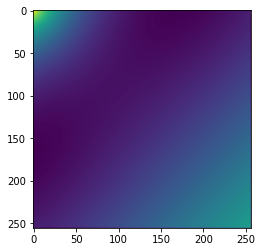

In [14]:
plt.imshow(pot)